Author: Zirui Zheng

## Pre-processing

In [83]:
import pandas as pd
import glob
import numpy as np
import datetime
import time
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
nlp = spacy.load('en')
%matplotlib inline

In [2]:
paths = glob.glob('./data/*.xlsx')
df = pd.ExcelFile(paths[0]).parse(0)
for path in paths[1:]:
    tmp = pd.ExcelFile(path).parse(0)
    df = pd.concat([df, tmp], ignore_index=True)

In [3]:
#Remove duplicates
data = df.drop_duplicates()

#Drop na and 60% empty columns
data = data.dropna(subset=['Sound Bite Text', 'No. of Followers/Daily Unique Visitors'])
drop_cols=[]
for col in df.columns:
    if df[col].isna().sum() > df.shape[0] * 0.4:
        drop_cols.append(col)
        
data = data.drop(columns=drop_cols)

#Keep only original posts
data = data[data['Post Type'] == 'Original']

#Convert Date
data = data.rename(columns = {'Published Date (GMT-04:00) New York':'Date'})
data['Date'] = pd.to_datetime(data['Date'],format="%b %d, %Y %I:%M:%S %p").dt.date

In [4]:
data.head()

,Post ID,Sound Bite Text,Source Type,Post Type,Media Type,URL,Domain,Date,Author Gender,Author URL,Author Name,No. of Followers/Daily Unique Visitors,Richness
0,11456927580853042662,With the iPhone 8 and iPhone 8 Plus already in...,Blogs,Original,Link,http://tweeterbird.blogspot.com/2017/10/apple-...,tweeterbird.blogspot.com,2017-10-25,Unknown,http://tweeterbird.blogspot.com/,Tweeter Bird,0.0,2.0
1,3723388671848181876,The following list showcases our pick of the b...,Blogs,Original,No Media,http://tweeterbird.blogspot.com/2017/10/best-f...,tweeterbird.blogspot.com,2017-10-25,Unknown,http://tweeterbird.blogspot.com/,Tweeter Bird,0.0,2.0
2,11827073999221105793,Apple iPhone 8 Plus 256GB Space Gray Factory ...,Blogs,Original,No Media,https://hellanordic.wordpress.com/2017/10/31/a...,hellanordic.wordpress.com,2017-10-31,Female,https://hellanordic.wordpress.com/,Hella,0.0,0.0
3,post_166779325437_359004079,"How to change the Galaxy S8, S8+, Note 8 ringt...",Tumblr,Original,Link,https://tumblr.com/ZDcSCd2RKqelz,tumblr.com,2017-10-25,Unknown,http://kofflereunices3713.tumblr.com,NaN,0.0,2.0
4,1636597625389503340_4220414469,Pumpkin Butter????❤️ So I’m posting a lot/arch...,Instagram,Original,Video,https://www.instagram.com/p/Ba2XN6FltNs/,instagram.com,2017-10-29,Unknown,https://www.instagram.com/sizzle.slimes,NaN,0.0,6.0


## Get Sentiment before and after launch

In [49]:
def get_sentiment(text): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(clean_text(text)) 
        # set sentiment 
        return analysis.sentiment.polarity

In [50]:
def clean_text(text): 
        ''' 
        Utility function to clean text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

In [51]:
def populate_sentiment(data):
    sent = []
    for i in range(len(data)):
        sent.append(get_sentiment(data.iloc[i]['Sound Bite Text']))
    return sent

In [52]:
#Constant variables to use
kw_dict = {'apple':['iphone', 'apple', 'ios'], 'samsung':['samsung', 'galaxy', 's8', 'note', 's7'], 
           'apple iphone x':['iphone x', 'iphone 10', 'iphonex', 'iphone10'], 
           'apple iphone 8': ['iphone 8', 'iphone8', 'plus']}
lc_dates = {'apple':datetime.date(2017,9,22), 'samsung':datetime.date(2017,3,29)}
start_dates = {'apple':datetime.date(2017,9,13), 'samsung':datetime.date(2017,3,13)}
end_dates = {'apple':datetime.date(2017,11,1), 'samsung':datetime.date(2017,6,7)}
products = ['Galaxy S8','Apple','Apple iPhone X', 'Apple iPhone 8']
genders = ['Female', 'Male']

In [53]:
def product_sentiment_launch_diff(data, prod):
    product = ''
    if prod == 'galaxy s8':
        product = 'samsung'
    else:
        product = prod
    data = data[data['Sound Bite Text'].str.contains('|'.join(kw_dict[product]), case=False)]
    
    brand = str.split(product, ' ')[0]
    lcdate, start, end = lc_dates[brand], start_dates[brand], end_dates[brand]
    prelaunch_df = data[(data['Date'] >= start) & (data['Date'] < lcdate)]
    postlaunch_df = data[(data['Date'] >= lcdate) & (data['Date'] <= end)]
    
    prelaunch_df['Sentiment'] = populate_sentiment(prelaunch_df)
    postlaunch_df['Sentiment'] = populate_sentiment(postlaunch_df)
    
    print('Pre_launch sentiment for %s is %s' %(prod, sum(prelaunch_df['Sentiment'])/len(prelaunch_df['Sentiment'])))
    print('Post_launch sentiment for %s is %s' %(prod, sum(postlaunch_df['Sentiment'])/len(postlaunch_df['Sentiment'])))
    
    return prelaunch_df, postlaunch_df

In [54]:
def display_sentiment_trend_products(data, products):
    result_dfs = []
    for p in products:
        pre_df, post_df = product_sentiment_launch_diff(data, p.lower())
        result_dfs.append(pre_df)
        result_dfs.append(post_df)
    
    num_dfs = len(result_dfs)
        
    fig, axes = plt.subplots(num_dfs//2, 2, sharey='row', figsize=(20, 4*num_dfs))
    fig.suptitle('Time Series Sentiment Analysis for all products')
    for i in range(0, num_dfs, 2):
        axes[i//2][i%2].plot(result_dfs[i].groupby(['Date'])['Sentiment'].mean())
        axes[i//2][i%2].set(ylabel='Sentiment')
        axes[i//2][i%2].set_title('Pre Launch for ' + products[i//2])
        axes[i//2][i%2+1].plot(result_dfs[i+1].groupby(['Date'])['Sentiment'].mean())
        axes[i//2][i%2+1].set_title('Post Launch for ' + products[i//2])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Pre_launch sentiment for galaxy s8 is 0.12424464176630122
Post_launch sentiment for galaxy s8 is 0.1606222114927035
Pre_launch sentiment for apple is 0.15432375713096994
Post_launch sentiment for apple is 0.15645688526888046
Pre_launch sentiment for apple iphone x is 0.1494253387177387
Post_launch sentiment for apple iphone x is 0.14891189629996165
Pre_launch sentiment for apple iphone 8 is 0.15452068365283064
Post_launch sentiment for apple iphone 8 is 0.15645315136136437


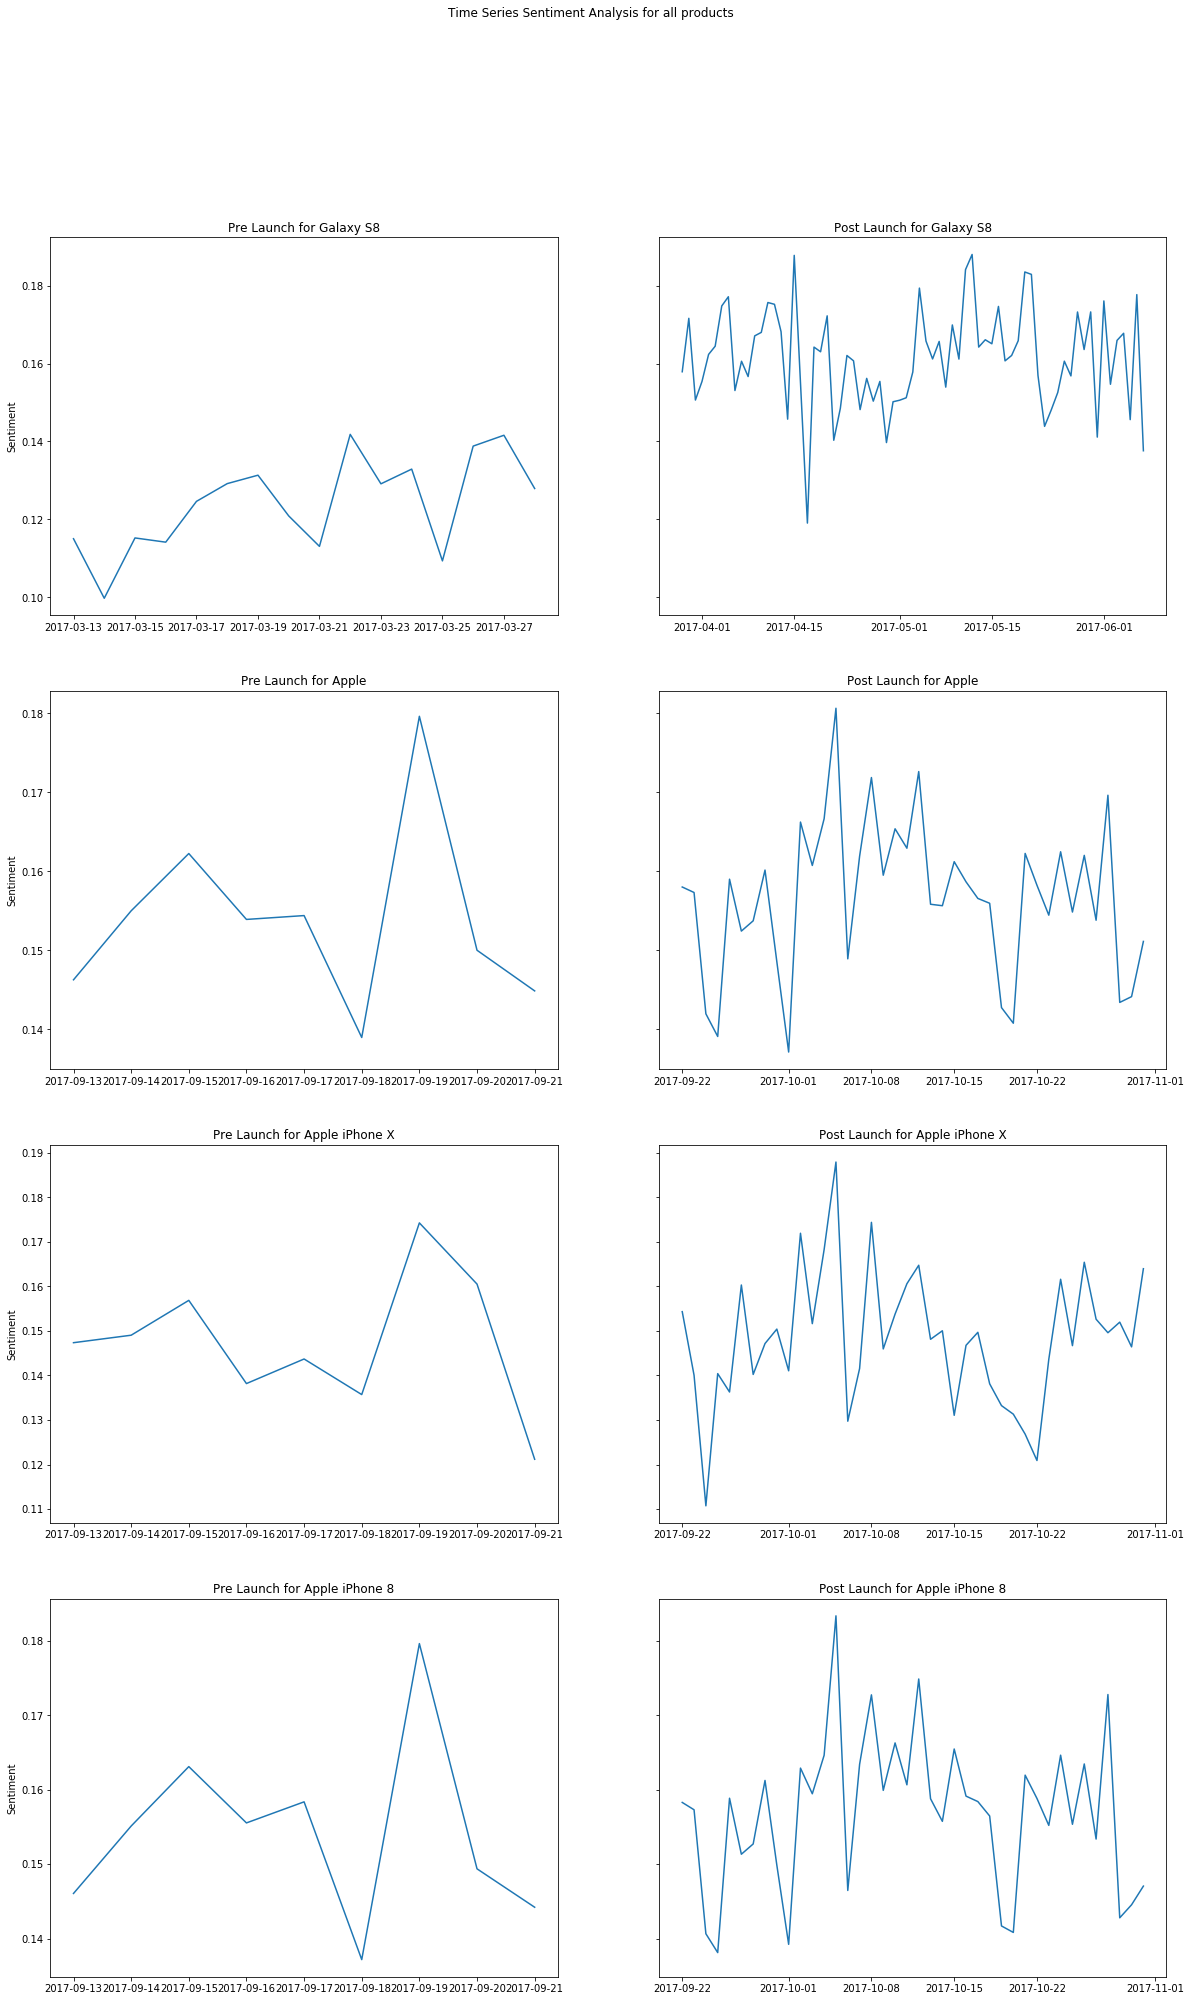

In [55]:
normal_user_data = data[data['No. of Followers/Daily Unique Visitors'] <= 2000]
display_sentiment_trend_products(normal_user_data, products)

## Get Sentiment from professionals and celebrities
(followers > 2000)

In [56]:
def product_sentiment_influencers(data, prod):
    product = ''
    if prod == 'galaxy s8':
        product = 'samsung'
    else:
        product = prod
    data = data[data['Sound Bite Text'].str.contains('|'.join(kw_dict[product]), case=False)]
    
    brand = str.split(product, ' ')[0]
    start, end = start_dates[brand], end_dates[brand]
    data = data[(data['Date'] >= start) & (data['Date'] <= end)]
    
    data['Sentiment'] = populate_sentiment(data)
    print('Sentiment from professionals and celebrities for %s is %s' 
          %(prod, sum(data['Sentiment'])/len(data['Sentiment'])))
    
    return data

In [57]:
def display_infdata_products(data, products):
    result_dfs = []
    for p in products:
        df = product_sentiment_influencers(data, p.lower())
        result_dfs.append(df)
    
    num_dfs = len(result_dfs)
        
    fig, axes = plt.subplots(num_dfs, 1, figsize=(20, 8*num_dfs))
    fig.suptitle('Time Series Sentiment Analysis from influncers for all products')
    for i in range(num_dfs):
        axes[i].plot(result_dfs[i].groupby(['Date'])['Sentiment'].mean())
        axes[i].set_title(products[i])
        if i == num_dfs-1:
            axes[i].set(xlabel='Date') 

Sentiment from professionals and celebrities for galaxy s8 is 0.15083234947685506
Sentiment from professionals and celebrities for apple is 0.14365817269551218
Sentiment from professionals and celebrities for apple iphone x is 0.14484059942469676
Sentiment from professionals and celebrities for apple iphone 8 is 0.14267387399790768


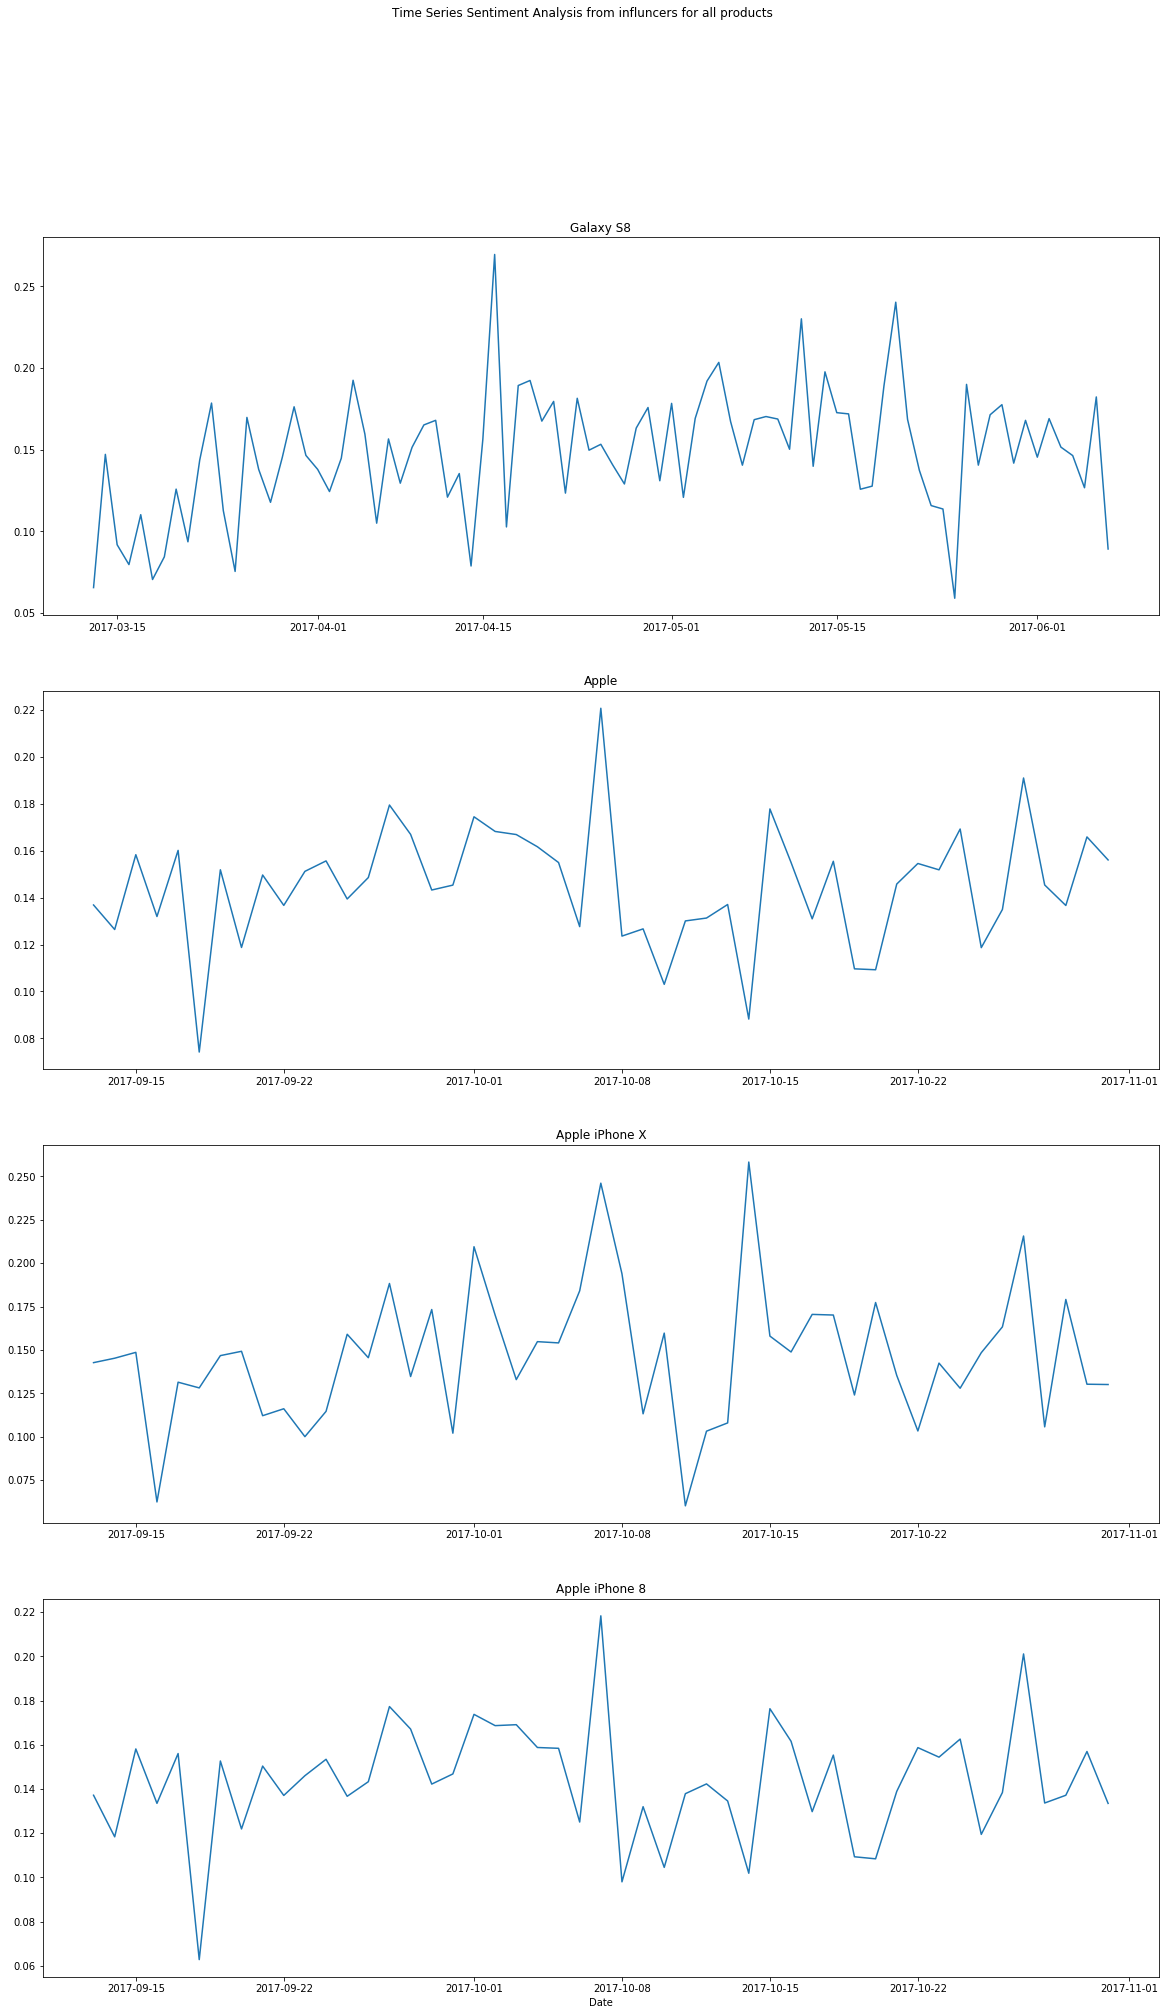

In [58]:
influencers_data = data[data['No. of Followers/Daily Unique Visitors'] > 2000]
display_infdata_products(influencers_data, products)

## Get Sentiment from Female and Male

In [59]:
def product_sentiment_gender(data, gender, prod):
    product = ''
    if prod == 'galaxy s8':
        product = 'samsung'
    else:
        product = prod
    data = data[(data['Sound Bite Text'].str.contains('|'.join(kw_dict[product]), case=False)) & (data['Author Gender']==gender)]
    
    brand = str.split(product, ' ')[0]
    start, end = start_dates[brand], end_dates[brand]
    data = data[(data['Date'] >= start) & (data['Date'] <= end)]
    
    data['Sentiment'] = populate_sentiment(data)
    print('Sentiment from %s for %s is %s' 
          %(gender, prod, sum(data['Sentiment'])/len(data['Sentiment'])))
    
    return data

In [60]:
def display_gender_products(data, genders, products):
    result_dfs = []
    for product in products:
        for gender in genders:
            result_dfs.append(product_sentiment_gender(data, gender, product.lower()))
    
    num_dfs = len(result_dfs)
    
    fig, axes = plt.subplots(num_dfs//2, 2, sharey='row', figsize=(20, 4*num_dfs))
    fig.suptitle('Time Series Sentiment Analysis for all products')
    for i in range(0, num_dfs, 2):
        axes[i//2][i%2].plot(result_dfs[i].groupby(['Date'])['Sentiment'].mean())
        axes[i//2][i%2].set(ylabel='Sentiment')
        axes[i//2][i%2].set_title('Sentiment for %s for %s' %(genders[i%2], products[i//2]))
        axes[i//2][i%2+1].plot(result_dfs[i+1].groupby(['Date'])['Sentiment'].mean())
        axes[i//2][i%2+1].set_title('Sentiment for %s for %s' %(genders[i%2+1], products[i//2]))

In [61]:
print(len(data[data['Author Gender']=='Female']), len(data[data['Author Gender']=='Male']))

15892 56324


Sentiment from Female for galaxy s8 is 0.17008978054464774
Sentiment from Male for galaxy s8 is 0.15986468023220984
Sentiment from Female for apple is 0.17596411353171132
Sentiment from Male for apple is 0.16061536826400982
Sentiment from Female for apple iphone x is 0.15480807957273268
Sentiment from Male for apple iphone x is 0.15286220092369
Sentiment from Female for apple iphone 8 is 0.17612804814043234
Sentiment from Male for apple iphone 8 is 0.16083325073794438


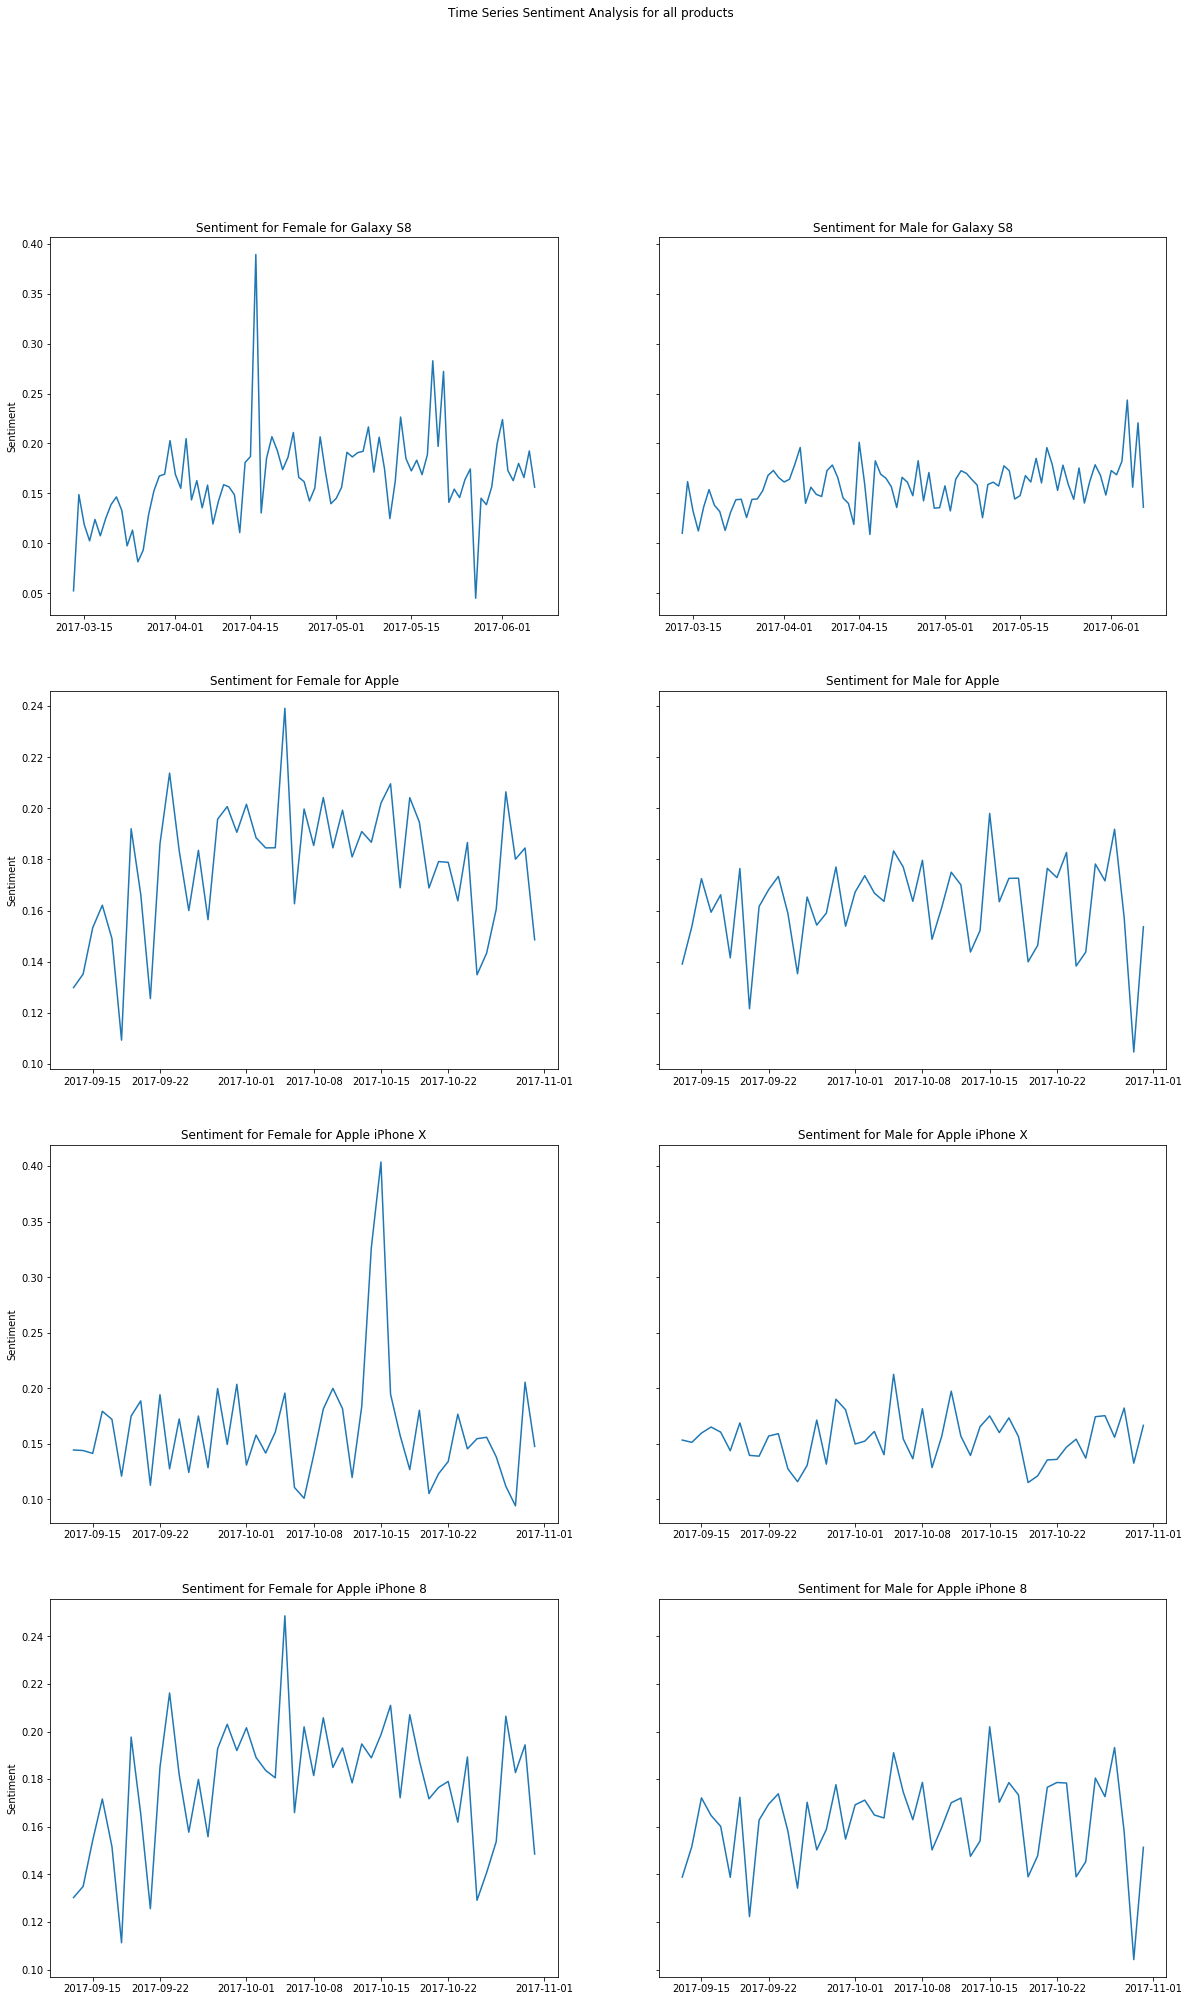

In [62]:
display_gender_products(data, genders, products)

## Get Sentiment across twitter / non-twitter platforms

In [66]:
def product_sentiment_platform(data, platform, prod):
    product = ''
    if prod == 'galaxy s8':
        product = 'samsung'
    else:
        product = prod
    brand = str.split(product, ' ')[0]
    start, end = start_dates[brand], end_dates[brand]
    data = data[(data['Date'] >= start) & (data['Date'] <= end) 
                & (data['Sound Bite Text'].str.contains('|'.join(kw_dict[product]), case=False))]
    
    if platform == 'Twitter':
        data = data[data['Source Type']=='Twitter']
    else:
        data = data[data['Source Type']!='Twitter']
    
    data['Sentiment'] = populate_sentiment(data)
    print('Sentiment from %s for %s is %s' 
          %(platform, prod, sum(data['Sentiment'])/len(data['Sentiment'])))
    
    return data

In [64]:
def display_platform_products(data, products):
    platform_list = ['Twitter', 'Other Sources']
    result_dfs = []
    for product in products:
        for platform in platform_list:
            result_dfs.append(product_sentiment_platform(data, platform, product.lower()))
    
    num_dfs = len(result_dfs)
    
    fig, axes = plt.subplots(num_dfs//2, 2, sharey='row', figsize=(20, 4*num_dfs))
    fig.suptitle('Time Series Sentiment Analysis for all products')
    for i in range(0, num_dfs, 2):
        axes[i//2][i%2].plot(result_dfs[i].groupby(['Date'])['Sentiment'].mean())
        axes[i//2][i%2].set(ylabel='Sentiment')
        axes[i//2][i%2].set_title('Sentiment for %s for %s' %(platform_list[i%2], products[i//2]))
        axes[i//2][i%2+1].plot(result_dfs[i+1].groupby(['Date'])['Sentiment'].mean())
        axes[i//2][i%2+1].set_title('Sentiment for %s for %s' %(platform_list[i%2+1], products[i//2]))

Sentiment from Twitter for galaxy s8 is 0.14145614816646018
Sentiment from Other Sources for galaxy s8 is 0.15750888699747684
Sentiment from Twitter for apple is 0.14255194156393147
Sentiment from Other Sources for apple is 0.15554239914577964
Sentiment from Twitter for apple iphone x is 0.1691628758989869
Sentiment from Other Sources for apple iphone x is 0.14863335385890888
Sentiment from Twitter for apple iphone 8 is 0.14060964271067536
Sentiment from Other Sources for apple iphone 8 is 0.15560811906422162


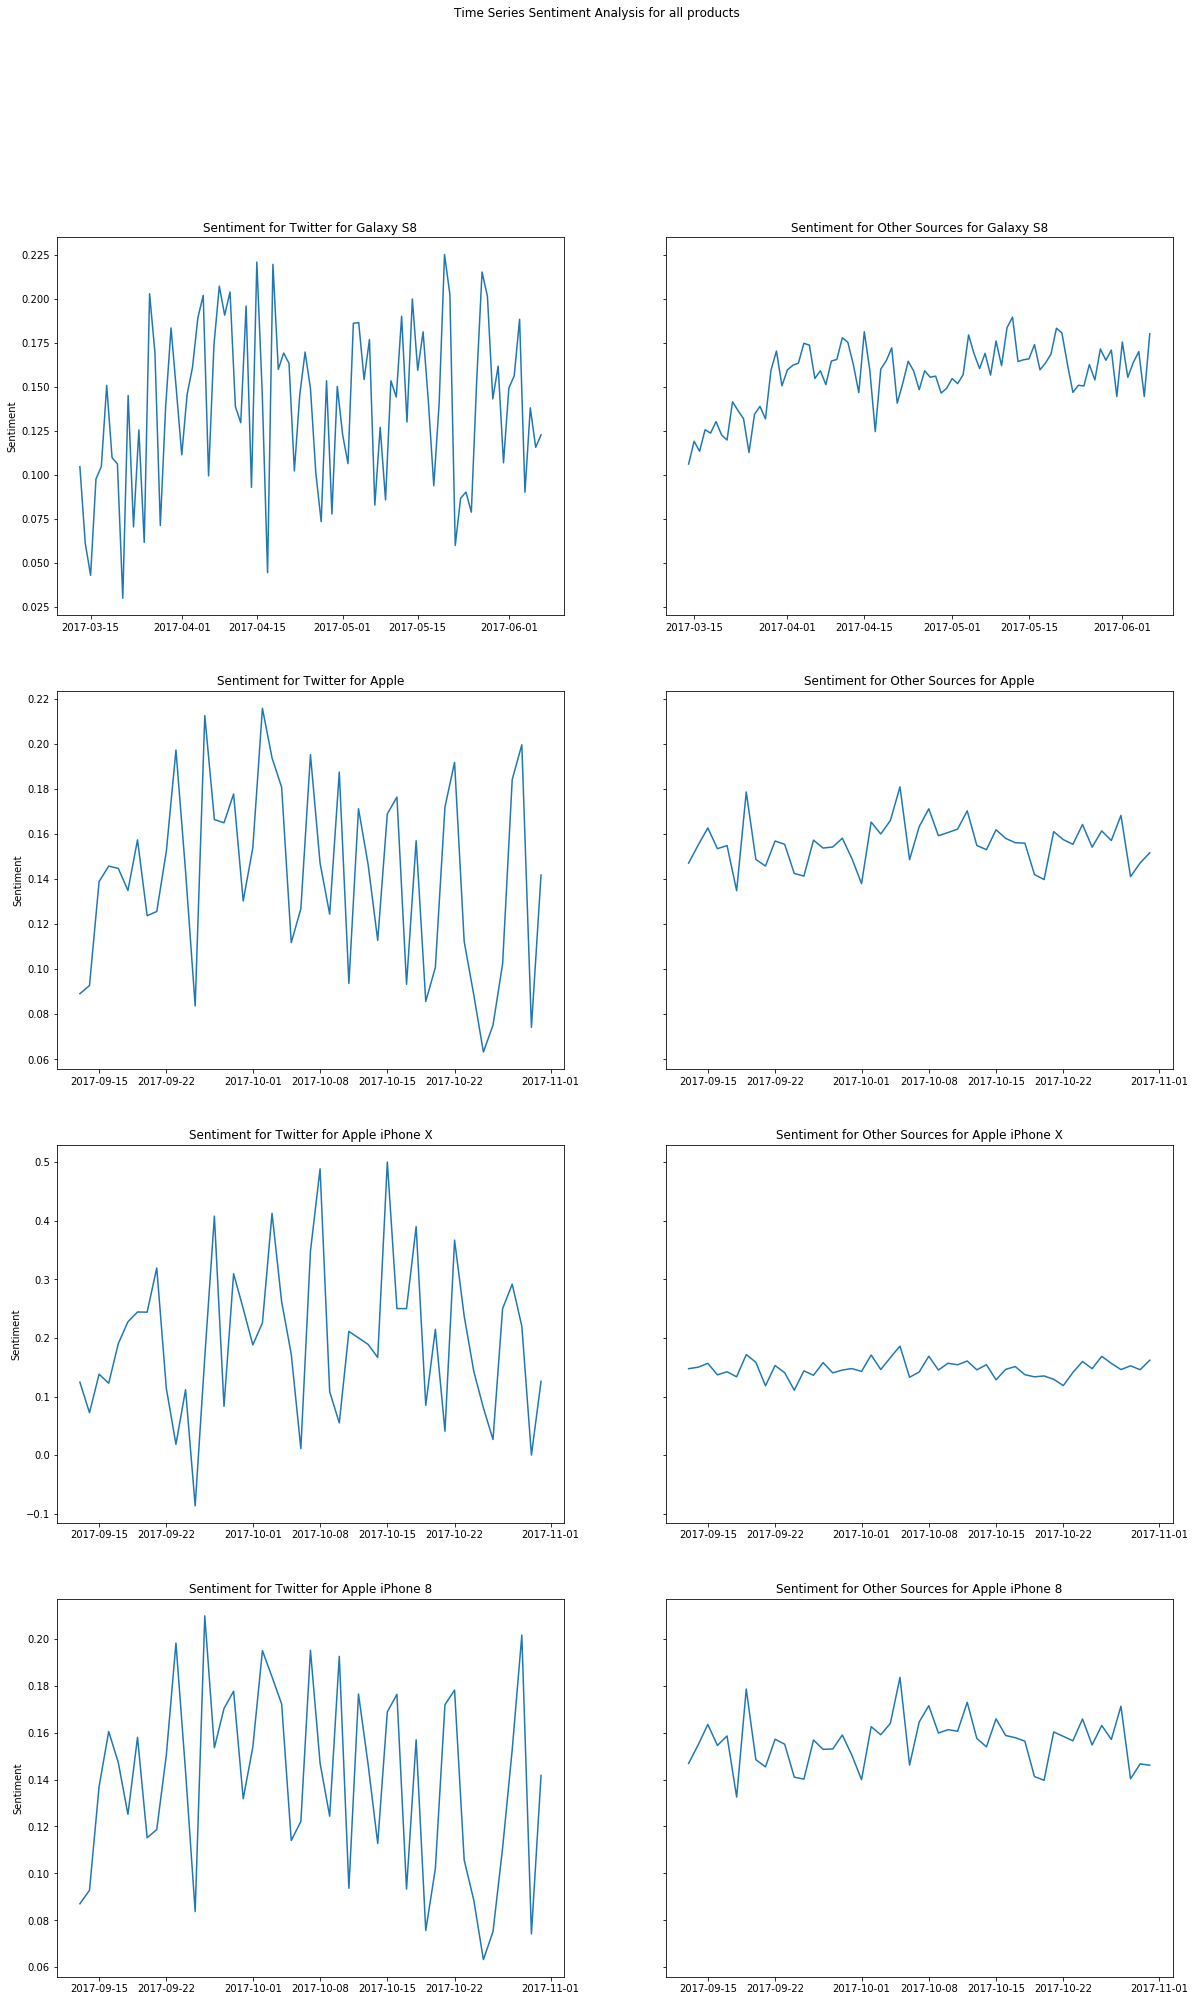

In [67]:
display_platform_products(data, products)

## WordCloud for good and bad sentiment

In [88]:
text_list = list(data['Sound Bite Text'])
good_list, bad_list = [], []
# indices = np.random.randint(0, len(text_list), 1000)
for i in range(len(text_list)):
    # create TextBlob object of passed tweet text 
    text = text_list[i]
    analysis = TextBlob(clean_text(text)) 
    # set sentiment 
    sent = analysis.sentiment.polarity
    words = analysis.words
    
    # add the lemma of the word
    if sent > 0:
        for w in words:
            good_list.append(w.lemmatize())
    else:
        for w in words:
            bad_list.append(w.lemmatize())

3.1607370376586914


In [85]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords.add('iphone')
stopwords.add('samsung')
stopwords.add('PRON')
stopwords.add('apple')
stopwords.add('plus')
stopwords.add('phone')
stopwords.add('8')
stopwords.add('x')
stopwords.add('s')
stopwords.add('t')
stopwords.add('ift')
stopwords.add('tt')
stopwords.add('http')
stopwords.add('galaxy')
stopwords.add('smartphone')
stopwords.add('s7')
stopwords.add('s8')
stopwords.add('lg')
stopwords.add('g6')
stopwords.add('https')

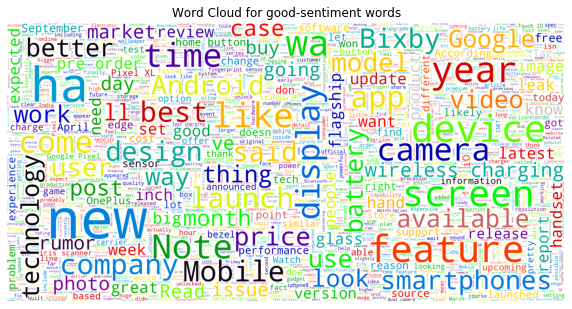

In [93]:
mask = skimage.io.imread('mask.png')
#We generate the wordcloud using the series created and the mask 
word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                    background_color="white", stopwords=stopwords, max_words=2000,
                    contour_width=1, contour_color="steelblue", 
                    colormap="nipy_spectral").generate(' '.join(good_list))
plt.figure(figsize=(10,10))
plt.title("Word Cloud for good-sentiment words")
plt.imshow(word_cloud, interpolation="hermite")
plt.axis("off")    
plt.show() 

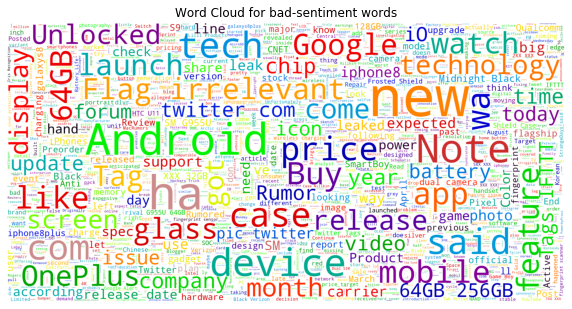

In [92]:
word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                    background_color="white", stopwords=stopwords, max_words=2000,
                    contour_width=1, contour_color="steelblue", 
                    colormap="nipy_spectral").generate(' '.join(bad_list))
plt.figure(figsize=(10,10))
plt.title("Word Cloud for bad-sentiment words")
plt.imshow(word_cloud, interpolation="hermite")
plt.axis("off")    
plt.show() 

## Clustering